<a href="https://colab.research.google.com/github/chalos18/COSC-Studies/blob/main/Data301_lab3_2025_student_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3: Association Rules, Cloud computing
In this lab you will complete two Parts:

1. Complete code to implement the naive and A-priori algorithms for finding
association rules. Test code “locally” in google colab.

2. Set up an account with Google Cloud Platform, deploy a cluster, and test dask job submissions on the cluster. You will then get empirical timing results for your A-priori algorithm on different cluster allocations.

**Note**: this lab uses a script to create, run, and destroy the cluster. This saves your credit$. If you cancel or crash sometimes you will need to check the GCP clusters page to make sure your cluster was destroyed (https://console.cloud.google.com/dataproc/clusters). If not, manually destroy it.


#Part 1 [50 points total]
Association Rules are frequently used for Market Basket Analysis (MBA) by retailers to understand the purchase behavior of their customers. This information can be then used for many different purposes such as recommendations, cross-selling and up-selling of products, sales promotions, loyalty programs, store design, discount plans and many others.

**Evaluation of item sets**: Once you have found the frequent itemsets of a dataset, you need to choose a subset of them that are significant and interesting. Commonly used metrics for measuring significance and interest for selecting rules for recommendations are:

* *Confidence*, conf(I -> j) = support(I u j) / support(I)
* *Interest*, interest(I -> j) = conf(I -> j) - Pr[j]

**Application in product recommendations**: The action or practice of selling additional products or services to existing customers is called cross-selling. Giving product recommendations is one of the examples of cross-selling that are frequently used by online retailers. One simple method to give product recommendations is to recommend products that are frequently browsed together by the customers. Suppose we want to recommend new products to the customer based on the products they have already browsed online.

We will first *find products which are frequently browsed together* and then *find interesting pair rules*.

##Loading data
In the given browsing.txt, each line represents a web browsing session of a customer (a “basket”). On each line, each string of 8 characters represents the ID of an item browsed during that session. The items are separated by spaces. For example, this first line of browsing.txt:

`FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 `

represents a browsing session (a “basket”) with 5 item IDs.

**NOTE:** We are using dask bags for most of this assignment because it is easier for unstructured text data.


In [ ]:
#imports
from math import isclose
import dask.array as da
import dask.bag as db
import urllib.request

url = 'https://drive.google.com/uc?export=download&confirm=t&id=1Ijyh14a0Lh9sjwQUR6PE1TB2phjAZP4P'
filename = "browsing.txt"
urllib.request.urlretrieve(url, filename)

text_file = db.read_text(filename)
print(f"{filename} loaded with {text_file.count().compute()} lines")

browsing.txt loaded with 31101 lines


##Question 1 [10 points]
Implement a naive approach to finding frequest product pairs with support = 100 (i.e. product pairs need to occur together at least 100 times to be considered frequent):

1. Create a bag from the lines in the file
2. Map each line into a list of all pairs of items in the basket.
Hint: this is an N^2 operation and can be done by writing a function with a nested loop that processes a single basket and then mapping this function over the dask bag
Hint: you can ensure that a pair is counted regardless of whether it appears in a basket as …,A,...,B,... or …,B,...,A,... by outputting it as tuple(sorted((item1, item2))) which would output (A,B) for both cases
3. Reduce the pairs into pair counts and return them
4. Test the top 5 most frequent pairs using the assert

Hints: use the frequencies function of dask bag!


In [ ]:
def naive(text_file_bag):
    def naive_check(line):
        result=[]
        text_file_mapped = line.strip().split()
        for i in range(len(text_file_mapped)):
          for j in range(i+1, len(text_file_mapped)):
              result.append(tuple(sorted((text_file_mapped[i], text_file_mapped[j]))))
        return result

    pair_counts=text_file_bag.map(naive_check).flatten()
    return pair_counts.frequencies()

In [ ]:
results_q1a = naive(text_file)
top5_q1a = results_q1a.topk(5, key=1)
print(top5_q1a.compute())

assert top5_q1a.compute() == [(('DAI62779', 'ELE17451'), 1592), (('FRO40251', 'SNA80324'), 1412),
 (('DAI75645', 'FRO40251'), 1254), (('FRO40251', 'GRO85051'), 1213),
 (('DAI62779', 'GRO73461'), 1139)]

[(('DAI62779', 'ELE17451'), 1592), (('FRO40251', 'SNA80324'), 1412), (('DAI75645', 'FRO40251'), 1254), (('FRO40251', 'GRO85051'), 1213), (('DAI62779', 'GRO73461'), 1139)]


##Question 2 [20 points total]

The naive approach can be slow and disk/memory intensive for large sets of browsing data. Improve this by implementing the two step A-priori algorithm.


###Question 2a [5 points]
Step 1 of the A-priori algorithm has its own function so we can test it

1. Create a bag from the lines in the file
2. Map each line into its items and then perform an item count on the entire bag (this is step 1 of the A-priori algorithm).

In [ ]:
def a_priori_step1(text_file_bag):
  item_counts = text_file_bag.map(lambda line: line.strip().split()).flatten().frequencies()
  return item_counts

In [ ]:
top5_q1b_step1 = a_priori_step1(text_file).topk(5, key=1)
print(top5_q1b_step1)
print(top5_q1b_step1.compute())
assert top5_q1b_step1.compute() == [('DAI62779', 6667), ('FRO40251', 3881),
                             ('ELE17451', 3875), ('GRO73461', 3602),
                             ('SNA80324', 3044)]

dask.bag<topk-aggregate, npartitions=1>
[('DAI62779', 6667), ('FRO40251', 3881), ('ELE17451', 3875), ('GRO73461', 3602), ('SNA80324', 3044)]


In [ ]:
top5_q1b_step1 = a_priori_step1(text_file).topk(5, key=1)
print(top5_q1b_step1.compute())
assert top5_q1b_step1.compute() == [('DAI62779', 6667), ('FRO40251', 3881),
                             ('ELE17451', 3875), ('GRO73461', 3602),
                             ('SNA80324', 3044)]

[('DAI62779', 6667), ('FRO40251', 3881), ('ELE17451', 3875), ('GRO73461', 3602), ('SNA80324', 3044)]


###Question 2b [10 points]
3. Filter the frequent items and keep only those with given number of occurrences (default is 100). You must then call .compute() and bring these back to the "client" python process so that they can be broadcast during Step 2 to every partition. I suggest storing them in a python set for best performance.
4. We can now begin Step 2 of the A-priori algorithm. This now follows the same as the naive algorithm except that when we map each line into a list of all pairs of items in the basket we first check to ensure that both items in the pair occur in the broadcast map from Step 1 of the A-priori algorithm. This significantly decreases the number of pairs that we output from this step.
5. Reduce the pairs into pair counts

**NOTE**: For best performance, don't call your a_priori_step1 function as this will require you to parse the line splits twice. Instead, copy that code into here and directly use the parsed line bag.

**HINT**: You can use the frequencies() function again to help with step 2!

In [ ]:
def a_priori(text_file_bag, support=100):
  item_counts = text_file_bag.map(lambda line: line.strip().split()).flatten().frequencies().compute()
  filtered_counts = {item[0] for item in item_counts if item[1] > support}
  def freq_pairs_gen(line):
        result=[]
        text_file_mapped = line.strip().split()
        for i in range(len(text_file_mapped)):
          for j in range(i+1, len(text_file_mapped)):
              if text_file_mapped[i] in filtered_counts and text_file_mapped[j] in filtered_counts:
                result.append(tuple(sorted((text_file_mapped[i], text_file_mapped[j]))))
        return result
  pair_counts2=text_file_bag.map(freq_pairs_gen).flatten()
  return pair_counts2.frequencies()

In [ ]:
results_q1b = a_priori(text_file)
print(results_q1b)
top5_q1b = results_q1b.topk(5, key=lambda x: x[1])
print(top5_q1b.compute())

assert top5_q1b.compute() == [(('DAI62779', 'ELE17451'), 1592), (('FRO40251', 'SNA80324'), 1412),
 (('DAI75645', 'FRO40251'), 1254), (('FRO40251', 'GRO85051'), 1213),
 (('DAI62779', 'GRO73461'), 1139)]

dask.bag<dictitems, npartitions=1>
[(('DAI62779', 'ELE17451'), 1592), (('FRO40251', 'SNA80324'), 1412), (('DAI75645', 'FRO40251'), 1254), (('FRO40251', 'GRO85051'), 1213), (('DAI62779', 'GRO73461'), 1139)]


### Question 2c [5 points]

The apriori algorithm should gain efficiency by generating only pairs where each item meets the given threshold of support. Thus a higher threshold should be faster. If we suspect the top 5 most frequent pairs have at least 1000 counts, then we can raise the threshold to 1000 and get the same result faster. In my reference implementation running the timing code gives:

```
naive took 8.355252504348755 seconds, apriori(100) took 6.176692724227905 seconds, and apriori(1000) took 1.8993971347808838 seconds
```



In [ ]:
import time

start_naive = time.time()
results_q1a = naive(text_file)
results_q1a.compute()#.takeOrdered(5, lambda kv: -kv[1])
end_naive = time.time()
top5_q1a = results_q1a.topk(5, lambda x: x[1]).compute()

start_apriori_100 = time.time()
results_q1b_100 = a_priori(text_file, 100)
results_q1b_100.compute()#.takeOrdered(5, lambda kv: -kv[1])
end_apriori_100 = time.time()
top5_q1b_100 = results_q1b_100.topk(5, lambda x: x[1]).compute()

start_apriori_1000 = time.time()
results_q1b_1000 = a_priori(text_file, 1000)
results_q1b_1000.compute()#.takeOrdered(5, lambda kv: -kv[1])
end_apriori_1000 = time.time()
top5_q1b_1000 = results_q1b_1000.topk(5, lambda x: x[1]).compute()

time_naive = end_naive - start_naive
time_apriori_100 = end_apriori_100 - start_apriori_100
time_apriori_1000 = end_apriori_1000 - start_apriori_1000


print(f"naive took {time_naive} seconds, apriori(100) took {time_apriori_100} seconds, and apriori(1000) took {time_apriori_1000} seconds")

naive took 7.044450521469116 seconds, apriori(100) took 3.67668080329895 seconds, and apriori(1000) took 1.3416845798492432 seconds


In [ ]:
assert top5_q1a == top5_q1b_100
assert top5_q1a == top5_q1b_1000
assert time_naive > time_apriori_100
assert time_apriori_100 > time_apriori_1000

## Question 3 [20 points total]

We would like to find interesting pair rules. Recall the definitions at the beginning of the lab for formulas.

### Setup

In [ ]:
top_item_counts = a_priori_step1(text_file).filter(lambda kv: kv[1]>=100)
print(top_item_counts)
top_pair_counts = a_priori(text_file, support=100)
print(top_pair_counts)
N = text_file.count().compute()

print(top_item_counts.topk(5, key=1).compute())
print(top_pair_counts.topk(5, key=1).compute())
print(N)

dask.bag<filter-lambda, npartitions=1>
dask.bag<dictitems, npartitions=1>
[('DAI62779', 6667), ('FRO40251', 3881), ('ELE17451', 3875), ('GRO73461', 3602), ('SNA80324', 3044)]
[(('DAI62779', 'ELE17451'), 1592), (('FRO40251', 'SNA80324'), 1412), (('DAI75645', 'FRO40251'), 1254), (('FRO40251', 'GRO85051'), 1213), (('DAI62779', 'GRO73461'), 1139)]
31101


### Question 3a [10 points]
Using the item pairs (X, Y) found in Question 1/2, compute the confidence score for the corresponding association rules X->Y and Y->X.

**HINT**: you should use the map and join functions

In [ ]:
def confidence(item_counts, pair_counts, n):
    mapped_x = pair_counts.map(lambda x: ((x[0][0], (x[0][1], x[1])), (x[0][1], (x[0][0], x[1]))))
    mapped_x_flattened = mapped_x.flatten()
    join_xy = item_counts.join(mapped_x_flattened, lambda x: x[0], lambda x: x[0])
    confidence_scores = join_xy.map(lambda x: ((x[0][0], x[0][1][0]), x[0][1][1] / x[1][1]))

    return confidence_scores

In [ ]:
rule_confidences = confidence(top_item_counts, top_pair_counts, N)
results_q2a = rule_confidences.topk(5, key=1)
print(results_q2a.compute())

[(('DAI93865', 'FRO40251'), 1.0), (('GRO85051', 'FRO40251'), 0.999176276771005), (('GRO38636', 'FRO40251'), 0.9906542056074766), (('ELE12951', 'FRO40251'), 0.9905660377358491), (('DAI88079', 'FRO40251'), 0.9867256637168141)]


In [ ]:
def all_close(list_frequencies_1, list_frequencies_2):
  return all([list_frequencies_1[i][0] == list_frequencies_2[i][0] and
              isclose(list_frequencies_1[i][1], list_frequencies_2[i][1]) for i in range(len(list_frequencies_1))])
assert all_close(results_q2a.compute(), [(('DAI93865', 'FRO40251'), 1.0),
                       (('GRO85051', 'FRO40251'), 0.9991762767710051),
                       (('GRO38636', 'FRO40251'), 0.9906542056074765),
                       (('ELE12951', 'FRO40251'), 0.9905660377358491),
                       (('DAI88079', 'FRO40251'), 0.9867256637168142)])

###Question 3b [10 points]
Compute the interest score for each rule.

**HINT**: you should use the map and join functions

In [ ]:
# Int(I - j) = conf(I -> j) - Pr[j] # which is just the support of j
def interest(item_counts, rule_confidences, n):

    conf = rule_confidences.map(lambda x: ((x[0][0], (x[0][1], x[1])), (x[0][1], (x[0][0], x[1]))))

    # Flatten to separate the I j and j I components
    map_conf_flat = conf.flatten()

    join_conf = item_counts.join(map_conf_flat, lambda x: x[0], lambda x: x[0][0])

    interest = join_conf.map(lambda x: ((x[0][0], x[0][1][0]), x[0][1][1] - (x[1][1] / n)))

    return interest

In [ ]:
rule_confidences = confidence(top_item_counts, top_pair_counts, N)
rule_interests = interest(top_item_counts, rule_confidences, N)
results_q2b = rule_interests.topk(5, key=1)
print(results_q2b.compute())

[]


In [ ]:
def all_close(list_frequencies_1, list_frequencies_2):
  return all([list_frequencies_1[i][0] == list_frequencies_2[i][0] and
              isclose(list_frequencies_1[i][1], list_frequencies_2[i][1]) for i in range(len(list_frequencies_1))])

assert all_close(results_q2b.compute(), [(('DAI43868', 'SNA82528'), 0.9538739086342056),
                       (('DAI93865', 'FRO40251'), 0.8752130156586605),
                       (('GRO85051', 'FRO40251'), 0.8743892924296656),
                       (('GRO38636', 'FRO40251'), 0.865867221266137),
                       (('ELE12951', 'FRO40251'), 0.8657790533945096)])

#Part 2 [50 points total] Google Cloud Platform



##Setup
###Step 1: Add Google Cloud Platform credits to your google account
You will need to have an account with google and a University of Canterbury email address to get started. Go to our UC Learn course page under Labs and click on the link to get your google cloud credits. You will be asked to provide your school email address and name. An email will be sent to you to confirm these details before a coupon is sent to you. **Please do not share this link outside of this course and please only use one coupon per student -- we have a limited number of these for use in DATA301**

###Step 2: Create a Google Cloud Platform project
Sign-in to Google Cloud Platform console at https://console.cloud.google.com/ and create a new project by clicking the drop-down box in the upper left corner:
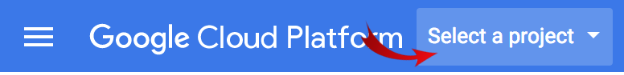


**Note: Your screen probably looks different.**

- When creating a new project, name it using the convention:
data301-lab03-2025-$

    where $ is replaced with your username (my project is named data301-lab03-2025-jatlas)

- Assign No Organisation. That way you can use your Google cloud education credits.

- Check that your billing for your project is using the Google cloud education credits by clicking the menu button in the upper left and going to the Billing->Overview. You should see the Billing Account for Education overview and your current credit usage:
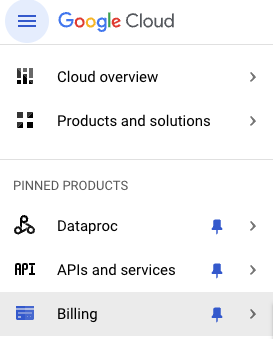


## Give permission for the cluster to write to bucket storage

Go to https://console.cloud.google.com/ and click on the menu -> IAM & Admin. You will need to edit the roles of the Compute Engine default service account and add the role "Storage Admin" so jobs on the cluster can write logs to a cloud storage bucket. If you don't see the default service account, you need to add the Compute Engine API to the project first:

1. Navigate to APIs & Services
2. Click Enable APIS and Services button
3. Scroll down to where it shows Compute Engine API, click on it
4. Press the Enable button

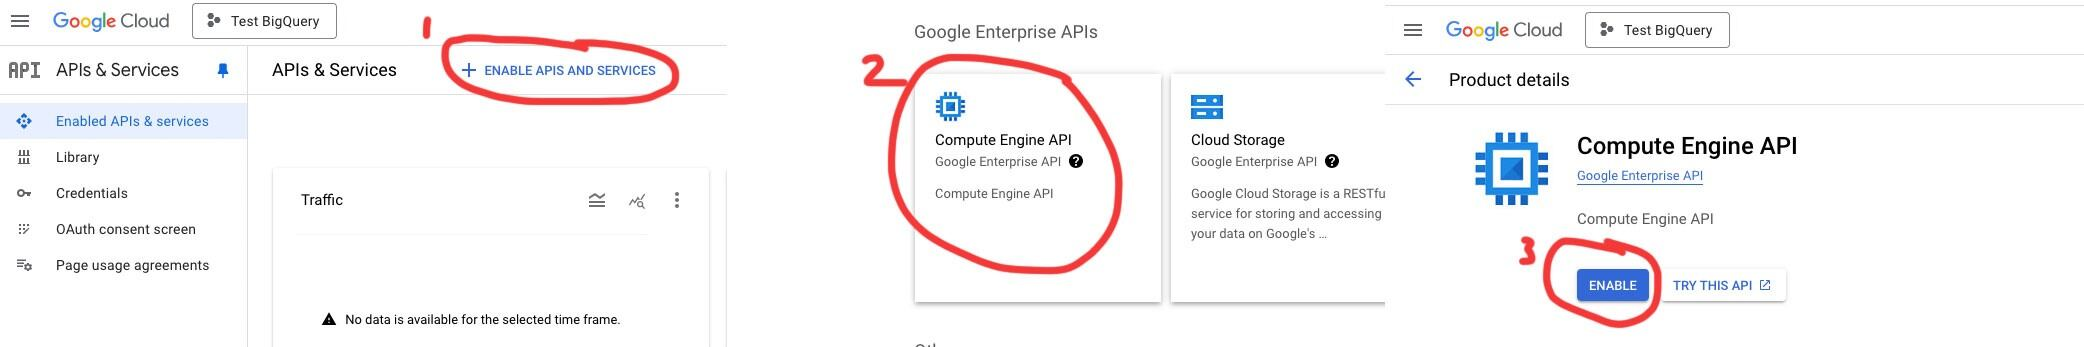

After editing the roles for the Compute Engine default service account, mine looks like:
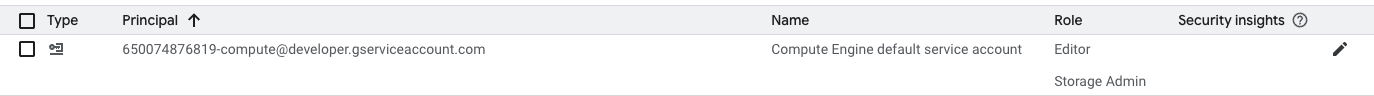

## Save a version of your A-Priori algorithm
We need to save a regular python file containing your version of the A-Priori algorithm for use on the cloud. In the next code box, paste your code for A-Priori. You should not need to change any other code.

The given script main function downloads a larger data file, starts a distributed client for use with n_cpus, and runs your A-Priori function inside of a dask profiler.

**NOTE: The file used earlier in this lab is not large enough to see any benefit of parallelism, but the one used here has duplicates in each line. When loading lines of data from this file you will want to convert it to a Python set to remove duplicates.** For example, if your original code did this:


```text_file_bag.map(lambda line: line.split())```

change it to

```text_file_bag.map(lambda line: set(line.split()))```




In [ ]:
%%writefile dask_apriori.py
# the above line tells colab to write the contents of this cell to a file instead of running them
import time
import sys
import multiprocessing
import os
import urllib.request

def a_priori(text_file_bag, support=1000):
  # PASTE YOUR CODE HERE (and then remove the following line)!
  raise(Exception("You forgot to paste your A-Priori code!"))


if __name__ == "__main__":
  url = 'https://drive.google.com/uc?export=download&confirm=t&id=1Red1JDV7S7smMIylsYerWnvYbUMpCBxJ'
  filename = "epinions_20000.txt"
  filename, _ = urllib.request.urlretrieve(url, filename)
  print(f"downloaded {filename}")

  support_threshold = 1000
  n_cpus = multiprocessing.cpu_count()

  if len(sys.argv) == 2:
    support_threshold = int(sys.argv[1])

  if len(sys.argv) == 3:
    n_cpus = int(sys.argv[2])

  from dask import bag as db
  from dask.distributed import LocalCluster
  from dask.distributed import Client
  from dask.distributed import get_task_stream

  cluster = LocalCluster(n_workers=n_cpus, threads_per_worker=1) # force to start 8 processes if we have 8 cpus
  print(cluster)
  client = cluster.get_client()

  with get_task_stream(plot='save', filename=f"task-stream-{n_cpus}.html") as ts:
    # force load of text file into partitions so that each process has one chunk
    file_stats = os.stat(filename)
    file_mb = file_stats.st_size / (1024 * 1024)
    b = db.read_text(filename, encoding='unicode_escape', blocksize=str((file_mb / n_cpus))+"MB")
    time_start = time.time()
    pair_counts = a_priori(b, support_threshold)
    print(pair_counts.topk(10, key=1).compute())
    time_end = time.time()
    print(f"elapsed time is {time_end - time_start}")

## Create a Dataproc cluster
We will use Google Cloud's pre-built Dataproc cluster to make it easier to start a set of virtual machines in the cloud that can run our code. In this lab we will start one node that has 8 virtual CPUs.

In [ ]:
# Edit this USERNAME string to set your username (for me this is "jatlas" instead of "?")
USERNAME="?"
%env REGION=australia-southeast1
%env ZONE=australia-southeast1-a
%env PROJECT=data301-lab05-2025-$USERNAME
%env CLUSTER=data301-lab05-2025-$USERNAME-cluster

In [ ]:
# Run this to prompt a log in so that this colab session can use your credentials to start the cluster
!gcloud auth login

In [ ]:
# Set the project environment variable and enable dataproc on it
!gcloud config set project $PROJECT
!gcloud services enable dataproc.googleapis.com cloudresourcemanager.googleapis.com

In [ ]:
# This command actually starts the cluster. It may take up to 5-10 minutes before
#  showing the completion dialog which should be
#  "Created [https://dataproc.googleapis.com/v1/projects/data301-lab03-2025-...] Cluster placed in zone [australia-southeast1-a]"
!gcloud dataproc clusters create $CLUSTER --region=$REGION --zone=$ZONE \
  --master-machine-type n2-standard-8 \
  --master-boot-disk-size 100 \
  --image-version 2.2-ubuntu22 \
  --max-age=30m \
  --public-ip-address \
  --num-masters=1 --num-workers=0

# NOTE: the above arguments should be self-explanatory; you can read more here: https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters/create
# The 30minute age will ensure the cluster shuts down if you forget or get disconnected from colab
# We only use 1 master node and 0 worker nodes as our 1 master node is an
#  n2-standard-8 which has 8 virtual CPUs

## Run your code in the cloud!

In [ ]:
# This command will send your dask_apriori.py file (which was saved in the earlier %%writefile cell)
#  to the cloud and run it within your cluster.
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 1000 1

# NOTE: The argument 1000 is the support threshold and 1 is the number of dask processes
#  it will use. For timing testing you will change this value to see how your
#  program scales with increased resources. At 1, only one of the virtual CPUs will be used.

# If your program is successful, output should include:
# [(('and', 'the'), 14298), (('a', 'the'), 14087), (('i', 'the'), 13563), ...
# elapsed time is 19.15696430206299

## Question 4: Test, record, and report timings

Change the n_cpus (P) argument in the above command so that you run your code with P = 1, 2, 3, 4, 5, 6, 7, 8 cpus. Record the time taken for each P value.

- Question 4a: [20 points] Create a graph of your data (in any software; matplotlib is easy) with number of cpus (P) on the X-axis and time on the Y-axis.
- Question 4b: [10 points] Compute speedup (Tseq / Tpar) for each setting of P, using Tseq = your P=1 data point. Create a graph with P on the X-axis and speedup on the Y-axis.
- Question 4c: [10 points] Discuss the trend that you see and what implications this has for how well our code scales vertically (i.e. as we add more processors)
- Question 4d: [10 points] Go to https://console.cloud.google.com/dataproc/clusters and click on the Jobs link. This will show you all of the jobs you have submitted and often has debug output in case a job failed. Take a screenshot of this and include it in your submission.

Submit text / screenshots for each of the above on the quiz server.
